<a href="https://colab.research.google.com/github/pjoachims/ml/blob/main/notebooks/cnn/style_transfer_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from copy import deepcopy

from imageio import imread
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

# Class and func defs

In [3]:
def get_torch_model(m: str, freeze_all: bool = True, **kw):
    # load network
    net = getattr(torchvision.models, m)(**kw)
    net.eval()
    
    # freeze parameters (if set)
    for para in net.parameters():
        para.requires_grad = False

    return net


def forward_pass_feature_maps(
        net, 
        image,
        max_idx,
    ) -> dict:
    x = image
    feature_maps = []
    i = 0
    for l in [module for module in net.modules() 
              if not isinstance(module, (nn.Sequential, type(net)))]:
    # for l in net.features:
        x = l(x)
        if isinstance(l, nn.Conv2d):
            i += 1
            feature_maps.append(x)
        if i == max_idx + 1:
            break

    return dict(zip(range(len(feature_maps)), feature_maps))


def gram_matrix(feature_map):
    batch_size, n_maps, c, d = feature_map.size()
    features = feature_map.view(batch_size * n_maps, c * d)
    G = torch.mm(features, features.t())
    return G.div(np.prod(feature_map.shape))


def get_image_as_np(data):
    try:
        data = imread(data)
    except OSError:
        pass

    if not isinstance(data, np.ndarray):
        data = np.ndarray(data)

    if len(data.shape) != 3:
        raise ValueError("invalid image data.")
    
    return data.copy()


def transform_im(
        im, 
        transforms, 
        unsqueeze_first: bool = True, 
        copy: bool = True,
        return_im_shape: bool = False,
    ) -> torch.Tensor:
    if not isinstance(im, torch.Tensor):
        # load if URI
        im = get_image_as_np(im)

    if copy:
        if isinstance(im, torch.Tensor):
            im = im.clone()
        else:
            im = deepcopy(im)

    shape = im.shape
    
    # init transforms
    if isinstance(transforms, list):
        transforms = T.transforms.Compose(transforms)
    if not isinstance(transforms, T.transforms.Compose):
        raise ValueError("transforms must be Compose or list of "
                            "transformations.")
    
    # apply transform (and add fake batch size)
    im = transforms(im)
    if unsqueeze_first:
        im = im.unsqueeze(0)

    if return_im_shape:
        return im, shape
    return im


def tensor_to_np_cpu(tensor):
    return tensor.cpu().detach().squeeze().numpy()


# Run conversion

In [30]:
model = "vgg19"
im_content = 'https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg'
# im_style = 'https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg'
im_style = "https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg"

transforms = [
    T.ToTensor(),
    T.Resize(512),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
]
content_layers_idx = {
    1: 1, 
    4: 4,
}
style_layers_idx = {
    1: 1,
    2: 0.5, 
    3: 0.5,
    4: 0.2,
    5: 0.1
}
num_steps = 1200
style_weight = 1e5
content_weight = 1

# set device
device = {True: torch.device('cuda'),
          False: torch.device('cpu')}[torch.cuda.is_available()]

# init images
im_content, size = transform_im(im_content, transforms, return_im_shape=True)
im_content = im_content.to(device)
im_style = transform_im(im_style, transforms)
im_style = im_style.to(device)
im_target = np.random.randint(low=0, high=255, size=size, dtype=np.uint8)
im_target = transform_im(im_target, transforms)
im_target = im_target.to(device)
im_target.requires_grad_(True)

# load model and push to device
net = get_torch_model(model, pretrained=True)
net.to(device)

# init optimizer
optimizer = torch.optim.RMSprop([im_target], lr=.005)

# get feature maps for content and style image
max_idx = 1 + max(np.hstack((list(content_layers_idx.keys()), 
                             list(style_layers_idx.keys()))))
fm_content = forward_pass_feature_maps(net, im_content, max_idx)
fm_style = forward_pass_feature_maps(net, im_style, max_idx)

target_images = []

for e in range(num_steps):
    # init losses
    loss_content, loss_style = 0, 0 

    # push current target through model and get feature maps
    fm_target = forward_pass_feature_maps(net, im_target, max_idx)

    # compute content and style loss
    for conv_idx, conv_fm in fm_target.items():
        if conv_idx in content_layers_idx:
            loss_content += F.mse_loss(conv_fm, 
                                       fm_content[conv_idx])
        if conv_idx in style_layers_idx:
            loss_style += style_layers_idx[conv_idx] * F.mse_loss(gram_matrix(conv_fm), 
                                                                  gram_matrix(fm_style[conv_idx]))
            
    loss_total = content_weight * loss_content + style_weight * loss_style

    # print(e, loss_content.item(), loss_style.item())
    if e % 100 == 0:
        target_images.append(im_target.clone())

    # backpropagation
    optimizer.zero_grad()
    loss_total.backward()
    optimizer.step()


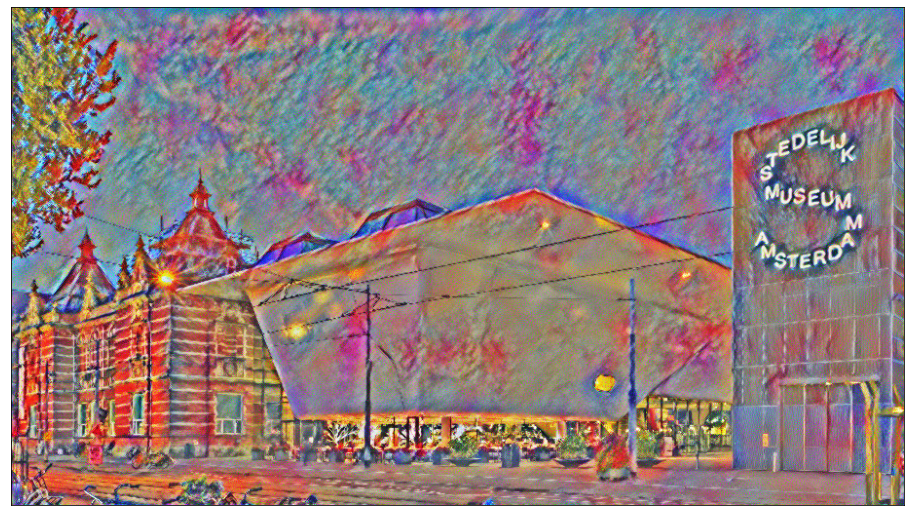

In [31]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

pic = tensor_to_np_cpu(im_target)
pic = sigmoid(pic)
pic = np.moveaxis(pic, 0, -1)

fig, ax = plt.subplots(1, 1, figsize=(16, 20))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(pic)